In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pylab as plt
import seaborn as sns
import joblib

/tmp/ipykernel_381363/3785633245.py:13: DeprecationWarning: FLIP_TOP_BOTTOM is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_TOP_BOTTOM instead.
  map_img = np.array(Image.open(map_path + map_ext).transpose(Image.FLIP_TOP_BOTTOM)).astype(np.float64)


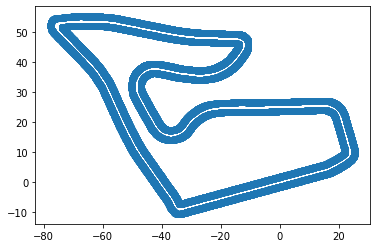

In [2]:
from PIL import Image
import yaml
def _get_map_points(map_path, map_ext):
    with open(map_path + '.yaml', 'r') as yaml_stream:
        try:
            map_metadata = yaml.safe_load(yaml_stream)
            map_resolution = map_metadata['resolution']
            origin = map_metadata['origin']
            origin_x = origin[0]
            origin_y = origin[1]
        except yaml.YAMLError as ex:
            print(ex)
    map_img = np.array(Image.open(map_path + map_ext).transpose(Image.FLIP_TOP_BOTTOM)).astype(np.float64)
    map_height = map_img.shape[0]
    map_width = map_img.shape[1]

    # convert map pixels to coordinates
    range_x = np.arange(map_width)
    range_y = np.arange(map_height)
    map_x, map_y = np.meshgrid(range_x, range_y)
    map_x = (map_x * map_resolution + origin_x).flatten()
    map_y = (map_y * map_resolution + origin_y).flatten()
    map_z = np.zeros(map_y.shape)
    map_coords = np.vstack((map_x, map_y, map_z))

    # mask and only leave the obstacle points
    map_mask = map_img == 0.0
    map_mask_flat = map_mask.flatten()
    map_points = map_coords[:, map_mask_flat].T
    return map_points[:,0], map_points[:,1]

map_x, map_y = _get_map_points("track_config/Spielberg_map", ".png")
plt.scatter(map_x, map_y)

In [3]:
center_trace = joblib.load("../../data/center_trace.pkl")
left_trace = joblib.load("../../data/left_trace.pkl")
right_trace = joblib.load("../../data/right_trace.pkl")
race_trace = joblib.load("../../data/race_trace.pkl")

In [4]:
dataset = list()

In [5]:
def _range(steering_values):
    return np.max(steering_values)-np.min(steering_values)

In [6]:
for trace in [center_trace, left_trace, right_trace, race_trace]:
    for i in range(15, (len(trace)-90)//10):
        dataset.append({
            'input': np.array([[trace[idx]['opp_x'], trace[idx]['opp_y'], trace[idx]['opp_theta'], trace[idx]['opp_deflection'], *trace[idx]['opp_forward_curvature']] for idx in range(i*10,(i*10)+10)], dtype=np.float32),
            'input_vel': np.array([[trace[idx]['opp_x'], trace[idx]['opp_y'], trace[idx]['opp_theta'], trace[idx]['opp_vel'], trace[idx]['opp_deflection'], *trace[idx]['opp_forward_curvature']] for idx in range(i*10,(i*10)+10)], dtype=np.float32),
            'input_no_curve': np.array([[trace[idx]['opp_x'], trace[idx]['opp_y'], trace[idx]['opp_theta']] for idx in range(i*10,(i*10)+10)], dtype=np.float32),
            'last_pose': np.array([trace[(i*10)+9]['opp_x'], trace[(i*10)+9]['opp_y'], trace[(i*10)+9]['opp_theta'], trace[(i*10)+9]['opp_vel']]),
            'steering_range': _range([trace[idx]['opp_steer'] for idx in range(i*10,(i*10)+10)]),
            'curvature_range': _range([trace[idx]['opp_forward_curvature'][:2] for idx in range(i*10,(i*10)+10)]),
            'target': np.array([[trace[idx]['opp_x'], trace[idx]['opp_y'], trace[idx]['opp_theta']] for idx in range((i*10)+10,(i+1)*10+60)]),
            'selected_lane': trace[0]['selected_lane']
        })

In [7]:
dataset[0]['input'].shape

(10, 9)

In [8]:
dataset_frame = pd.DataFrame(dataset)

In [9]:
dataset_frame

,input,input_vel,input_no_curve,last_pose,steering_range,curvature_range,target,selected_lane
0,"[[-40.162144, 16.563124, 5.689377, -0.21777019...","[[-40.162144, 16.563124, 5.689377, 3.4212914, ...","[[-40.162144, 16.563124, 5.689377], [-40.13379...","[-39.904030281959244, 16.39785013042315, 5.732...",0.056472,0.005443,"[[-39.87525008462397, 16.380174182096347, 5.73...",center
1,"[[-39.87525, 16.380175, 5.7389665, -0.21150316...","[[-39.87525, 16.380175, 5.7389665, 3.3731234, ...","[[-39.87525, 16.380175, 5.7389665], [-39.84639...","[-39.6123158688247, 16.2310509056982, 5.787960...",0.056811,0.007024,"[[-39.58298856019122, 16.21521068862056, 5.794...",center
2,"[[-39.58299, 16.21521, 5.79443, -0.20122054, 0...","[[-39.58299, 16.21521, 5.79443, 3.3291745, -0....","[[-39.58299, 16.21521, 5.79443], [-39.553596, ...","[-39.31559555804573, 16.082695727216045, 5.855...",0.055633,0.007019,"[[-39.28563265825731, 16.069042444697764, 5.86...",center
3,"[[-39.285633, 16.069042, 5.8620143, -0.1870633...","[[-39.285633, 16.069042, 5.8620143, 3.2890577,...","[[-39.285633, 16.069042, 5.8620143], [-39.2556...","[-39.01311066284438, 15.955888233000334, 5.909...",0.053009,0.005621,"[[-38.98277138016194, 15.944002977072085, 5.91...",center
4,"[[-38.982773, 15.944003, 5.91614, -0.16857345,...","[[-38.982773, 15.944003, 5.91614, 3.2542217, -...","[[-38.982773, 15.944003, 5.91614], [-38.952396...","[-38.707546624014014, 15.846945294009535, 5.96...",0.052631,0.005554,"[[-38.676898632169724, 15.837009864617764, 5.9...",center
...,...,...,...,...,...,...,...,...
2873,"[[-23.28998, 23.87518, 0.3683079, -0.5744877, ...","[[-23.28998, 23.87518, 0.3683079, 5.7145667, -...","[[-23.28998, 23.87518, 0.3683079], [-23.236666...","[-22.808374153999313, 24.055610646741165, 0.34...",0.011189,0.010142,"[[-22.754613508311373, 24.075000485490516, 0.3...",race
2874,"[[-22.754614, 24.075, 0.34060797, -0.44552335,...","[[-22.754614, 24.075, 0.34060797, 5.7151847, -...","[[-22.754614, 24.075, 0.34060797], [-22.700745...","[-22.268060588153542, 24.242068219594785, 0.31...",0.017780,0.011125,"[[-22.213757952977566, 24.259969713605873, 0.3...",race
2875,"[[-22.213758, 24.25997, 0.31289938, -0.3174619...","[[-22.213758, 24.25997, 0.31289938, 5.718029, ...","[[-22.213758, 24.25997, 0.31289938], [-22.1593...","[-21.722353651642006, 24.413616697580313, 0.29...",0.017265,0.010323,"[[-21.667511299009128, 24.430025084593698, 0.2...",race
2876,"[[-21.667511, 24.430025, 0.28516573, -0.384108...","[[-21.667511, 24.430025, 0.28516573, 5.72506, ...","[[-21.667511, 24.430025, 0.28516573], [-21.612...","[-21.171309875047836, 24.57018330985659, 0.262...",0.018359,0.011675,"[[-21.115932853475513, 24.58508980968446, 0.26...",race


In [10]:
dataset_frame.iloc[0]['input'][:,1]

array([16.563124, 16.54398 , 16.525143, 16.506512, 16.487991, 16.469671,
       16.451454, 16.433483, 16.41565 , 16.39785 ], dtype=float32)

Text(0.5, 1.0, '0.056471531497155614')

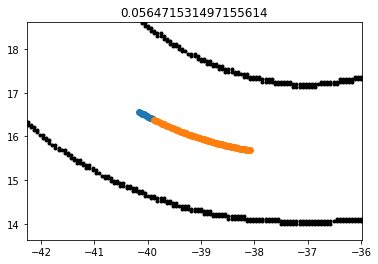

In [11]:
DATA_IDX = 0
plt.plot(dataset_frame.iloc[DATA_IDX]['input'][:,0], dataset_frame.iloc[DATA_IDX]['input'][:,1], marker='o')
plt.plot(dataset_frame.iloc[DATA_IDX]['target'][:,0], dataset_frame.iloc[DATA_IDX]['target'][:,1], marker='o')
xlim, ylim = plt.gca().get_xlim(), plt.gca().get_ylim()
plt.scatter(map_x, map_y, marker=".", color='black')
plt.gca().set_xlim((xlim[0]-2,xlim[1]+2))
plt.gca().set_ylim((ylim[0]-2,ylim[1]+2))
plt.title(dataset_frame.iloc[DATA_IDX]['steering_range'])

Text(0.5, 1.0, '0.543344674103681')

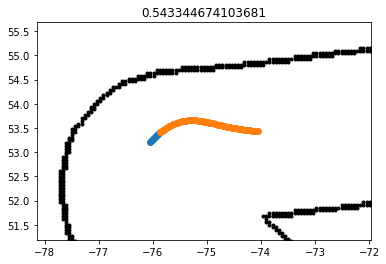

In [12]:
DATA_IDX = dataset_frame['steering_range'].idxmax()
plt.plot(dataset_frame.iloc[DATA_IDX]['input'][:,0], dataset_frame.iloc[DATA_IDX]['input'][:,1], marker='o')
plt.plot(dataset_frame.iloc[DATA_IDX]['target'][:,0], dataset_frame.iloc[DATA_IDX]['target'][:,1], marker='o')
xlim, ylim = plt.gca().get_xlim(), plt.gca().get_ylim()
plt.scatter(map_x, map_y, marker=".", color='black')
plt.gca().set_xlim((xlim[0]-2,xlim[1]+2))
plt.gca().set_ylim((ylim[0]-2,ylim[1]+2))
plt.title(dataset_frame.iloc[DATA_IDX]['steering_range'])

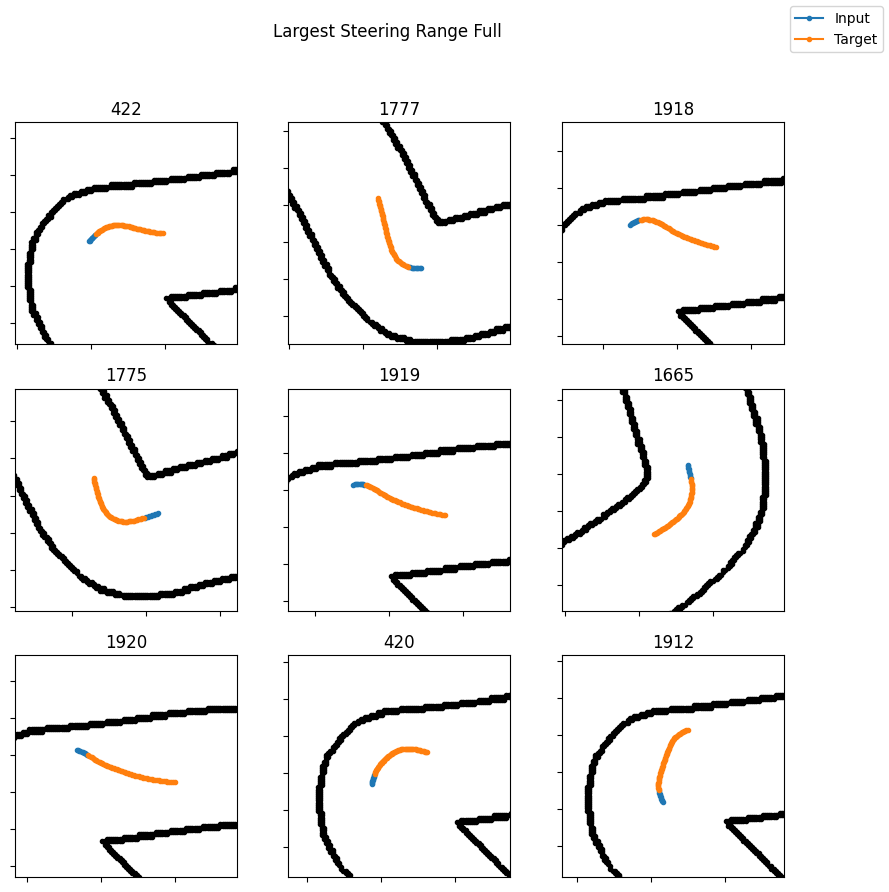

In [13]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10), dpi=100)
for idx, DATA_IDX in enumerate(dataset_frame['steering_range'].sort_values(ascending=False).index[:10][:9]):
    linput, = axs[idx // 3, idx % 3].plot(dataset_frame.iloc[DATA_IDX]['input'][:, 0],
                                          dataset_frame.iloc[DATA_IDX]['input'][:, 1], marker='.', label="Input")
    ltarget, = axs[idx // 3, idx % 3].plot(dataset_frame.iloc[DATA_IDX]['target'][:, 0],
                                           dataset_frame.iloc[DATA_IDX]['target'][:, 1], marker='.', label="Target")
    xlim, ylim = np.average(axs[idx // 3, idx % 3].get_xlim()), np.average(axs[idx // 3, idx % 3].get_ylim())
    axs[idx // 3, idx % 3].scatter(map_x, map_y, marker=".", color='black')
    axs[idx // 3, idx % 3].set(xlim=(xlim - 3, xlim + 3),
                               ylim=(ylim - 3, ylim + 3),
                               aspect=1.0,
                               adjustable='box',
                               yticklabels=[],
                               xticklabels=[])
    axs[idx // 3, idx % 3].set_title("{}".format(DATA_IDX))
fig.suptitle("Largest Steering Range Full")
fig.legend(handles=[linput, ltarget])
fig.show()

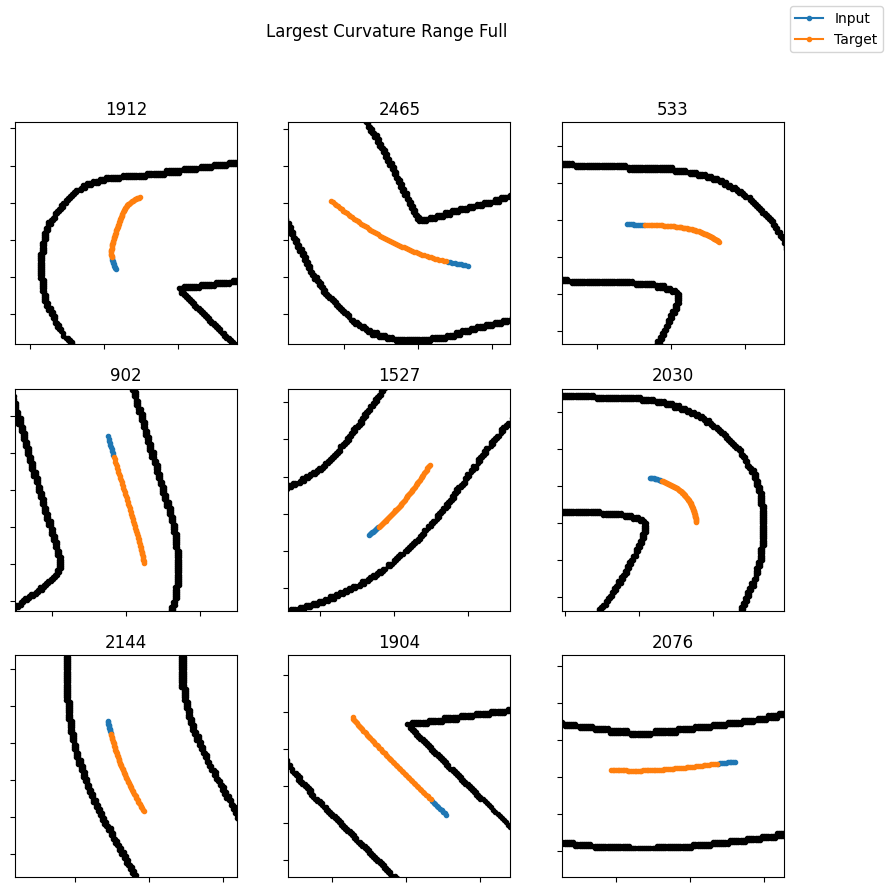

In [14]:
fig, axs = plt.subplots(3,3,figsize=(10,10), dpi=100)
for idx, DATA_IDX in enumerate(dataset_frame['curvature_range'].sort_values(ascending=False).index[::60][:9]):
    linput, = axs[idx//3, idx%3].plot(dataset_frame.iloc[DATA_IDX]['input'][:,0], dataset_frame.iloc[DATA_IDX]['input'][:,1], marker='.', label="Input")
    ltarget, = axs[idx//3, idx%3].plot(dataset_frame.iloc[DATA_IDX]['target'][:,0], dataset_frame.iloc[DATA_IDX]['target'][:,1], marker='.', label="Target")
    xlim, ylim = np.average(axs[idx//3, idx%3].get_xlim()), np.average(axs[idx//3, idx%3].get_ylim())
    axs[idx//3, idx%3].scatter(map_x, map_y, marker=".", color='black')
    axs[idx//3, idx%3].set(xlim=(xlim-3,xlim+3),
                           ylim=(ylim-3,ylim+3),
                           aspect=1.0,
                           adjustable='box',
                           yticklabels=[],
                           xticklabels=[])
    axs[idx//3, idx%3].set_title("{}".format(DATA_IDX))
fig.suptitle("Largest Curvature Range Full")
fig.legend(handles=[linput, ltarget])
fig.show()

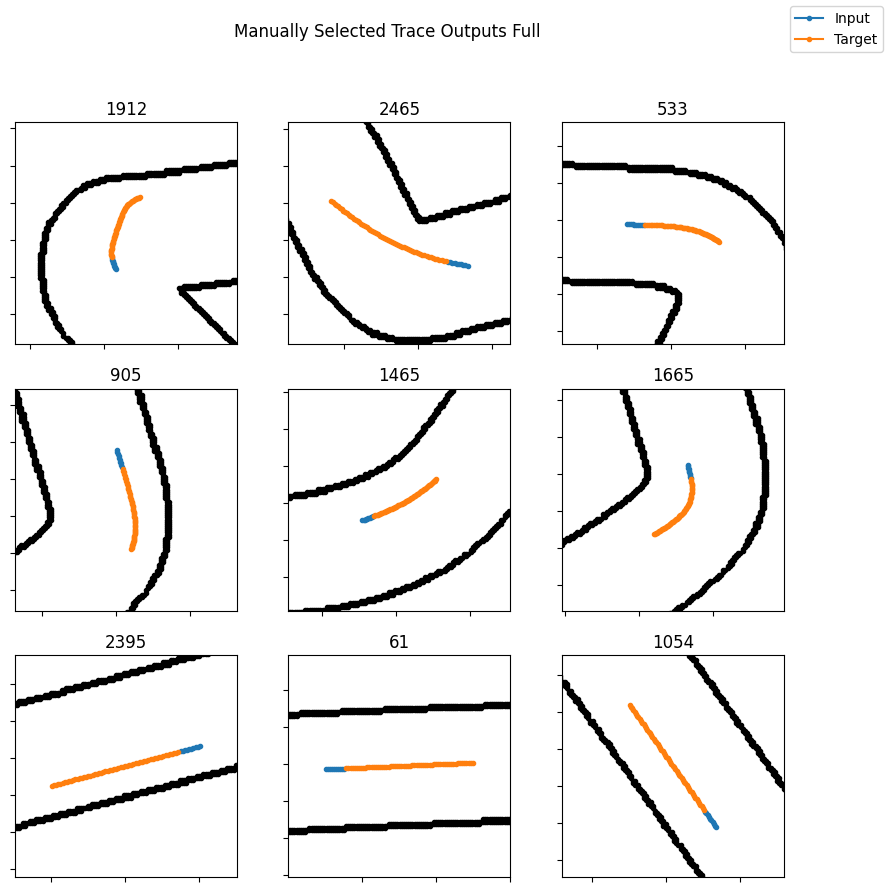

In [15]:
fig, axs = plt.subplots(3,3,figsize=(10,10), dpi=100)
for idx, DATA_IDX in enumerate([1912, 2465, 533, 905, 1465, 1665, 2395, 61, 1054]):
    linput, = axs[idx//3, idx%3].plot(dataset_frame.iloc[DATA_IDX]['input'][:,0], dataset_frame.iloc[DATA_IDX]['input'][:,1], marker='.', label="Input")
    ltarget, = axs[idx//3, idx%3].plot(dataset_frame.iloc[DATA_IDX]['target'][:,0], dataset_frame.iloc[DATA_IDX]['target'][:,1], marker='.', label="Target")
    xlim, ylim = np.average(axs[idx//3, idx%3].get_xlim()), np.average(axs[idx//3, idx%3].get_ylim())
    axs[idx//3, idx%3].scatter(map_x, map_y, marker=".", color='black')
    axs[idx//3, idx%3].set(xlim=(xlim-3,xlim+3),
                           ylim=(ylim-3,ylim+3),
                           aspect=1.0,
                           adjustable='box',
                           yticklabels=[],
                           xticklabels=[])
    axs[idx//3, idx%3].set_title("{}".format(DATA_IDX))
fig.suptitle("Manually Selected Trace Outputs Full")
fig.legend(handles=[linput, ltarget])
fig.show()

In [16]:
dataset_frame.to_pickle("../../data/final_data.pkl")

In [17]:
from sklearn.model_selection import train_test_split
TEST_FRAC = 0.2
classes = dataset_frame['selected_lane']
train_frame, test_frame = train_test_split(dataset_frame,stratify=classes, test_size=TEST_FRAC)

In [18]:
train_frame.groupby(['selected_lane']).count()

,input,input_vel,input_no_curve,last_pose,steering_range,curvature_range,target
selected_lane,,,,,,,
center,595,595,595,595,595,595,595
left,607,607,607,607,607,607,607
race,516,516,516,516,516,516,516
right,584,584,584,584,584,584,584


In [19]:
test_frame.groupby(['selected_lane']).count()

,input,input_vel,input_no_curve,last_pose,steering_range,curvature_range,target
selected_lane,,,,,,,
center,149,149,149,149,149,149,149
left,152,152,152,152,152,152,152
race,129,129,129,129,129,129,129
right,146,146,146,146,146,146,146


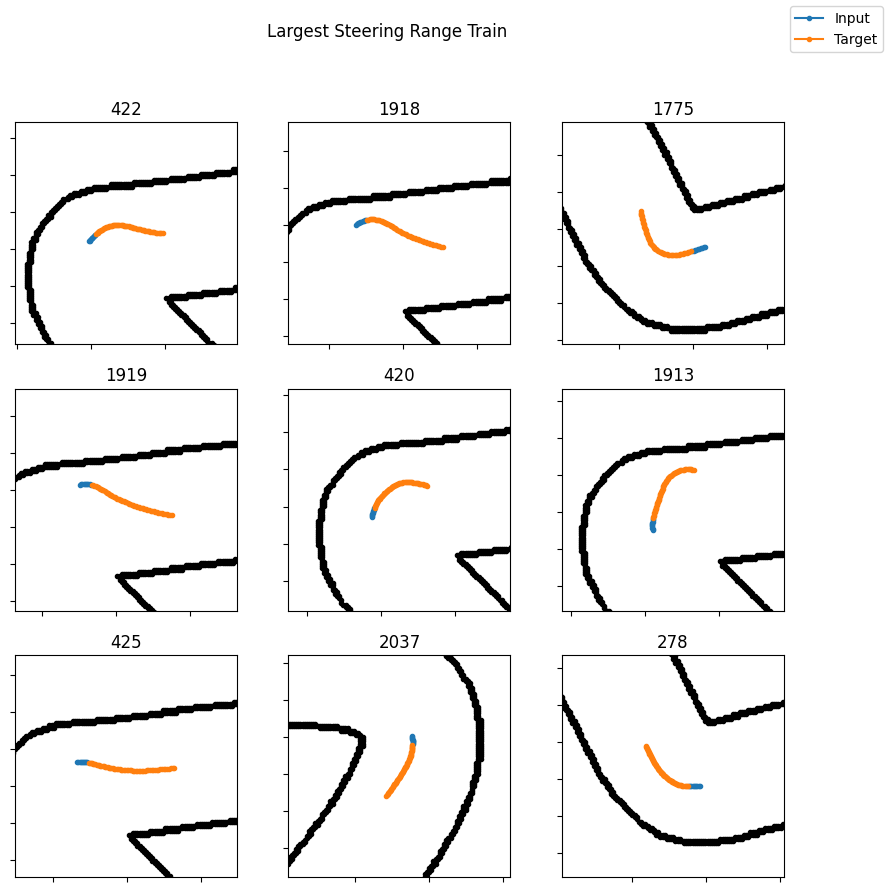

In [20]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10), dpi=100)
for idx, DATA_IDX in enumerate(train_frame['steering_range'].sort_values(ascending=False).index[:9]):
    linput, = axs[idx // 3, idx % 3].plot(train_frame.loc[DATA_IDX]['input'][:, 0],
                                          train_frame.loc[DATA_IDX]['input'][:, 1], marker='.', label="Input")
    ltarget, = axs[idx // 3, idx % 3].plot(train_frame.loc[DATA_IDX]['target'][:, 0],
                                           train_frame.loc[DATA_IDX]['target'][:, 1], marker='.', label="Target")
    xlim, ylim = np.average(axs[idx // 3, idx % 3].get_xlim()), np.average(axs[idx // 3, idx % 3].get_ylim())
    axs[idx // 3, idx % 3].scatter(map_x, map_y, marker=".", color='black')
    axs[idx // 3, idx % 3].set(xlim=(xlim - 3, xlim + 3),
                               ylim=(ylim - 3, ylim + 3),
                               aspect=1.0,
                               adjustable='box',
                               yticklabels=[],
                               xticklabels=[])
    axs[idx // 3, idx % 3].set_title("{}".format(DATA_IDX))
fig.suptitle("Largest Steering Range Train")
fig.legend(handles=[linput, ltarget])
fig.show()

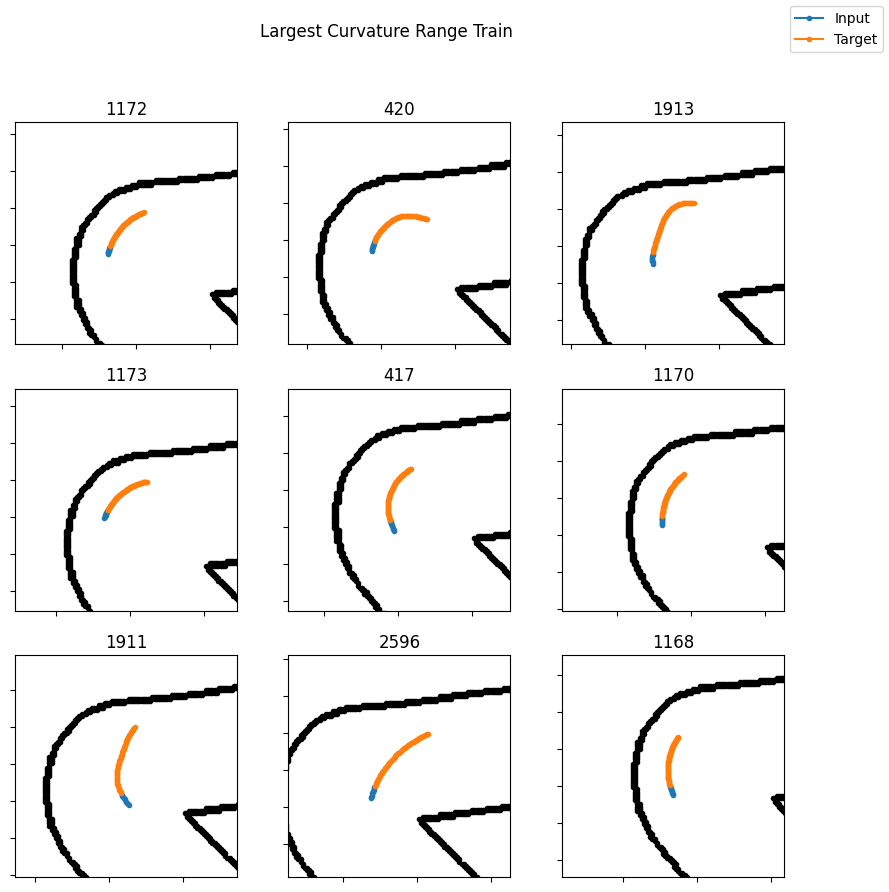

In [21]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10), dpi=100)
for idx, DATA_IDX in enumerate(train_frame['curvature_range'].sort_values(ascending=False).index[:9]):
    linput, = axs[idx // 3, idx % 3].plot(train_frame.loc[DATA_IDX]['input'][:, 0],
                                          train_frame.loc[DATA_IDX]['input'][:, 1], marker='.', label="Input")
    ltarget, = axs[idx // 3, idx % 3].plot(train_frame.loc[DATA_IDX]['target'][:, 0],
                                           train_frame.loc[DATA_IDX]['target'][:, 1], marker='.', label="Target")
    xlim, ylim = np.average(axs[idx // 3, idx % 3].get_xlim()), np.average(axs[idx // 3, idx % 3].get_ylim())
    axs[idx // 3, idx % 3].scatter(map_x, map_y, marker=".", color='black')
    axs[idx // 3, idx % 3].set(xlim=(xlim - 3, xlim + 3),
                               ylim=(ylim - 3, ylim + 3),
                               aspect=1.0,
                               adjustable='box',
                               yticklabels=[],
                               xticklabels=[])
    axs[idx // 3, idx % 3].set_title("{}".format(DATA_IDX))
fig.suptitle("Largest Curvature Range Train")
fig.legend(handles=[linput, ltarget])
fig.show()

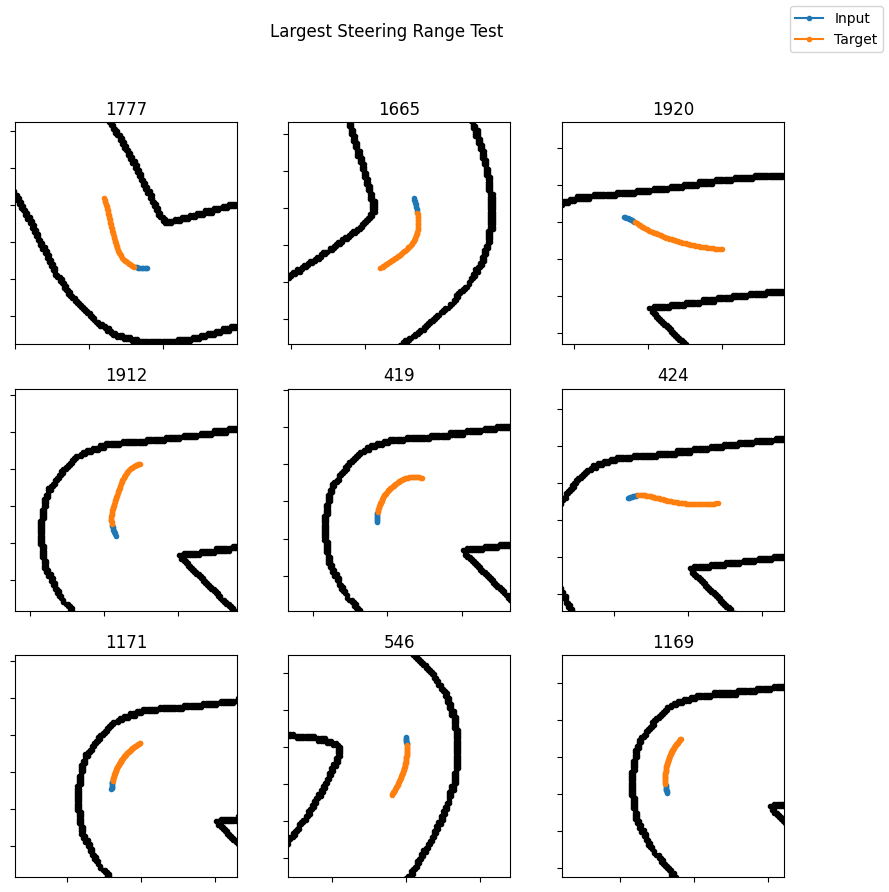

In [22]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10), dpi=100)
for idx, DATA_IDX in enumerate(test_frame['steering_range'].sort_values(ascending=False).index[:9]):
    linput, = axs[idx // 3, idx % 3].plot(test_frame.loc[DATA_IDX]['input'][:, 0],
                                          test_frame.loc[DATA_IDX]['input'][:, 1], marker='.', label="Input")
    ltarget, = axs[idx // 3, idx % 3].plot(test_frame.loc[DATA_IDX]['target'][:, 0],
                                           test_frame.loc[DATA_IDX]['target'][:, 1], marker='.', label="Target")
    xlim, ylim = np.average(axs[idx // 3, idx % 3].get_xlim()), np.average(axs[idx // 3, idx % 3].get_ylim())
    axs[idx // 3, idx % 3].scatter(map_x, map_y, marker=".", color='black')
    axs[idx // 3, idx % 3].set(xlim=(xlim - 3, xlim + 3),
                               ylim=(ylim - 3, ylim + 3),
                               aspect=1.0,
                               adjustable='box',
                               yticklabels=[],
                               xticklabels=[])
    axs[idx // 3, idx % 3].set_title("{}".format(DATA_IDX))
fig.suptitle("Largest Steering Range Test")
fig.legend(handles=[linput, ltarget])
fig.show()

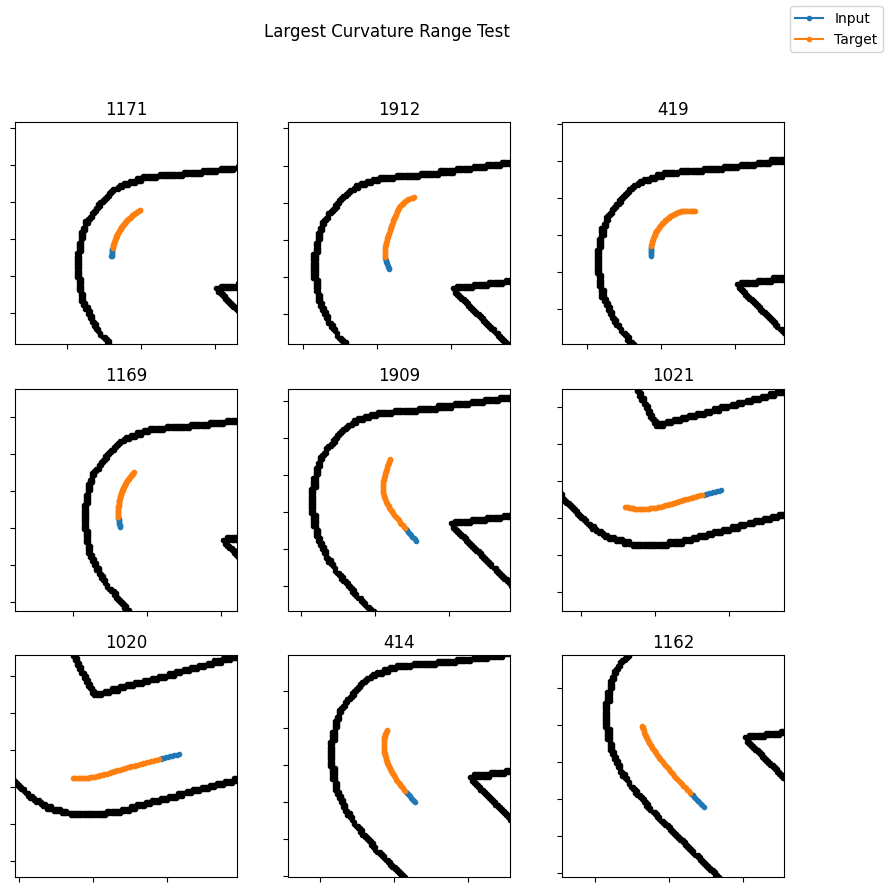

In [23]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10), dpi=100)
for idx, DATA_IDX in enumerate(test_frame['curvature_range'].sort_values(ascending=False).index[:9]):
    linput, = axs[idx // 3, idx % 3].plot(test_frame.loc[DATA_IDX]['input'][:, 0],
                                          test_frame.loc[DATA_IDX]['input'][:, 1], marker='.', label="Input")
    ltarget, = axs[idx // 3, idx % 3].plot(test_frame.loc[DATA_IDX]['target'][:, 0],
                                           test_frame.loc[DATA_IDX]['target'][:, 1], marker='.', label="Target")
    xlim, ylim = np.average(axs[idx // 3, idx % 3].get_xlim()), np.average(axs[idx // 3, idx % 3].get_ylim())
    axs[idx // 3, idx % 3].scatter(map_x, map_y, marker=".", color='black')
    axs[idx // 3, idx % 3].set(xlim=(xlim - 3, xlim + 3),
                               ylim=(ylim - 3, ylim + 3),
                               aspect=1.0,
                               adjustable='box',
                               yticklabels=[],
                               xticklabels=[])
    axs[idx // 3, idx % 3].set_title("{}".format(DATA_IDX))
fig.suptitle("Largest Curvature Range Test")
fig.legend(handles=[linput, ltarget])
fig.show()

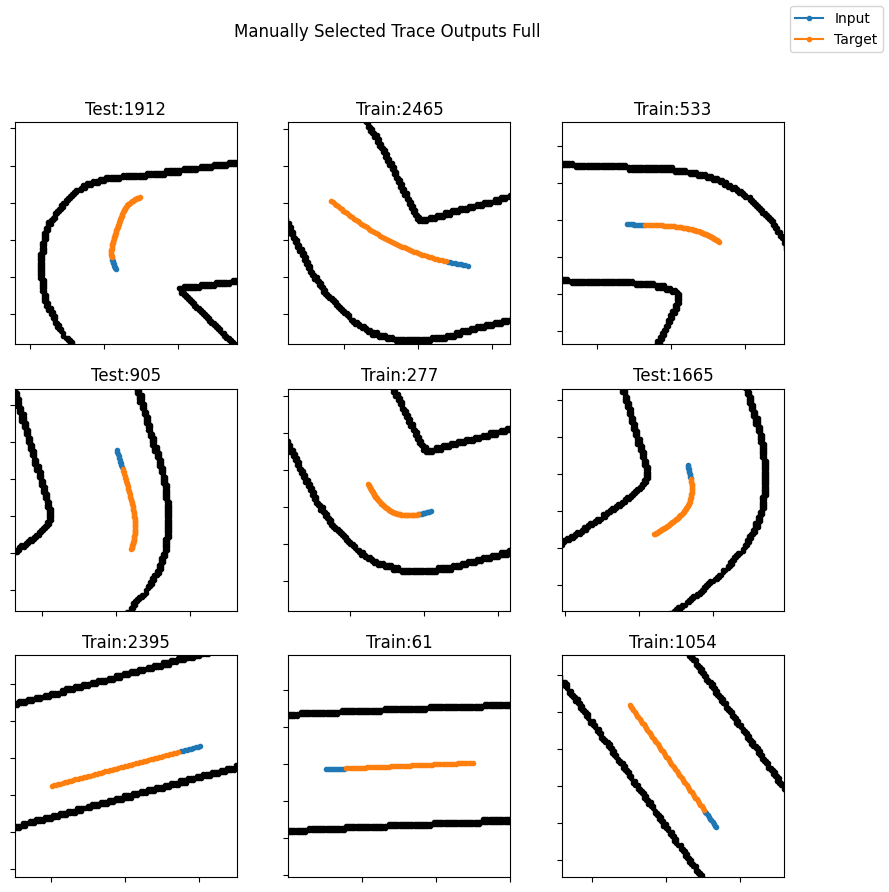

In [24]:
fig, axs = plt.subplots(3,3,figsize=(10,10), dpi=100)
for idx, DATA_IDX in enumerate([1912, 2465, 533, 905, 277, 1665, 2395, 61, 1054]):
    data_in_train = True if DATA_IDX in train_frame.index else False
    if data_in_train:
        dframe = train_frame
    else:
        dframe = test_frame
    linput, = axs[idx//3, idx%3].plot(dframe.loc[DATA_IDX]['input'][:,0], dframe.loc[DATA_IDX]['input'][:,1], marker='.', label="Input")
    ltarget, = axs[idx//3, idx%3].plot(dframe.loc[DATA_IDX]['target'][:,0], dframe.loc[DATA_IDX]['target'][:,1], marker='.', label="Target")
    xlim, ylim = np.average(axs[idx//3, idx%3].get_xlim()), np.average(axs[idx//3, idx%3].get_ylim())
    axs[idx//3, idx%3].scatter(map_x, map_y, marker=".", color='black')
    axs[idx//3, idx%3].set(xlim=(xlim-3,xlim+3),
                           ylim=(ylim-3,ylim+3),
                           aspect=1.0,
                           adjustable='box',
                           yticklabels=[],
                           xticklabels=[])
    axs[idx//3, idx%3].set_title("{}:{}".format("Train" if data_in_train else "Test",DATA_IDX))
fig.suptitle("Manually Selected Trace Outputs Full")
fig.legend(handles=[linput, ltarget])
fig.show()

In [25]:
train_frame.to_pickle("../../data/train_data.pkl")
test_frame.to_pickle("../../data/test_data.pkl")

In [41]:
dframe.loc[DATA_IDX]['input'][-3:11,:3]

array([[-40.88254   ,  -0.7821823 ,   2.1858308 ],
       [-40.915993  ,  -0.7348283 ,   2.18021   ],
       [-40.949207  ,  -0.68724525,   2.18021   ]], dtype=float32)

In [36]:
dframe.loc[DATA_IDX]['last_pose']

array([-40.94920818,  -0.68724524,   2.18021006,   5.80777558])

In [37]:
dframe.loc[DATA_IDX]['target'][0,:3]

array([-40.98245112,  -0.63962243,   2.17457977])